# 正态性检验和蒙特卡洛完成投资组合优化


最近一直在思考怎样有效的配置资产组合。
很多时候根据条件选好股票池之后，通常简单粗暴的等分仓位给每只股票。
其实，这个过程中有很多可以优化的空间。

下面，给大家分享一下如何运用**有效前沿**进行资产组合优化。

## PART ONE: 正态性检验


### **1.导入模块**

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt
import tushare as ts
from cvxopt import solvers, matrix

%matplotlib inline

### **2.选取几只感兴趣的股票。**

* 510300 沪市 华泰柏瑞沪深300ETF ETF-场内
* 511210 博时上证企债30ETF
* 513500 标普500ETF基金

* 备选：
* 511010 国泰上证5年期国债ETF

In [2]:
# 数据获取接口 获取通联DataFrame
def get_data(secidList):
    """
    输入secid + 日期，获得以此估计出来的年化方差协方差矩阵
    """
    da = []
    for each in secidList:
        print each
        hist_data_each = ts.get_hist_data(each, "2016-04-28")
        da += [hist_data_each['close']]
    data = pd.concat(da, axis=1)
    data.columns = secidList
    return data

In [3]:
hs300 = ts.get_hist_data('510220', "2016-04-28")  # 获取沪深300指数k线数据
stock = ['510300','510210','513500']
# stock = ['004232', '003629', '002808','000025', '000754']
noa = len(stock) # number of asset
data = get_data(stock)

510300
510210
513500


#获取基金的净值调整信息，包括基金分红和基金拆分两种调整情况
ts.set_token("91f997544ba2429d46abedc4a6f7a3eb6cac1b17d7f6c251633c824aafdb4b3f")
ts.get_token()
fd = ts.Fund()

df = fd.FundDiv(ticker='184688', adjustedType='D',beginDate='20000101', field='secShortName,effectDate,publishDate,dividendAfTax,dividendBfTax')

fd.FundDiv(ticker='184688', adjustedType='D',beginDate='20000101', field='secShortName,effectDate,publishDate,dividendAfTax,dividendBfTax')

### **3.比较一下机制股票的情况。规范起点为100.**

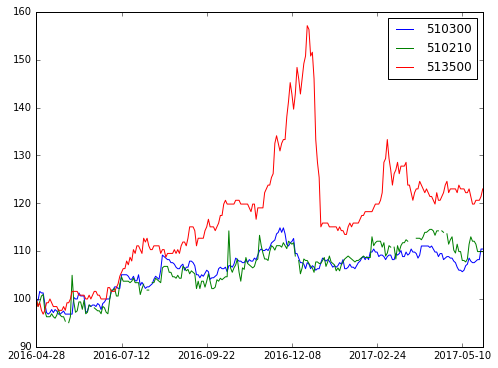

In [4]:

(data/data.ix[0]*100).plot(figsize = (8,6))

### **4.计算收益率**

用pandas计算收益率会比Numpy效率高一些，可以用shift方法

In [5]:
def get_log_ret(data):
    return np.log(data/data.shift(1)).fillna(0.0)
retData = get_log_ret(data)
retData.head()

,510300,510210,513500
2016-04-28,0.000000,0.000000,0.000000
2016-04-29,-0.003170,-0.015601,-0.016000
2016-05-03,0.018868,0.009390,0.008032
2016-05-04,-0.003120,0.012384,-0.016129
2016-05-05,0.000000,0.003072,-0.008163


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000003C8A3C8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000034EA96A0>]], dtype=object)

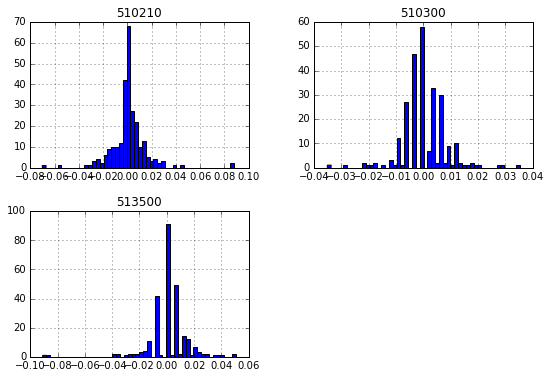

In [6]:
retData.hist(bins = 50, figsize = (9,6))

从以上结果看到4个数据集都和正态分布的要求相差太多。

### **5.输出每只股票的统计数据**

In [7]:
#定义print_statistics函数，为了更加易于理解的方式
#输出给定(历史或者模拟)数据集均值、偏斜度或者峰度等统计数字
def print_statistics(array):
    sta = scs.describe(array)
    print '%14s %15s' %('statistic','value')
    print 30*'-'
    print '%14s %15d' %('size', sta[0])
    print '%14s %15.5f' %('min', sta[1][0])
    print '%14s %15.5f' %('max', sta[1][1])
    print '%14s %15.5f' %('mean', sta[2])
    print '%14s %15.5f' %('std', np.sqrt(sta[3]))
    print '%14s %15.5f' %('skew', sta[4])
    print '%14s %15.5f' %('kurtosis', sta[5])

for st in stock:
    print '\nResults for stock %s' %st
    print 30*'-'
    log_data = np.array(retData[st].dropna())
    print_statistics(log_data)


Results for stock 510300
------------------------------
     statistic           value
------------------------------
          size             263
           min        -0.03520
           max         0.03532
          mean         0.00038
           std         0.00792
          skew         0.02515
      kurtosis         4.01383

Results for stock 510210
------------------------------
     statistic           value
------------------------------
          size             263
           min        -0.07015
           max         0.08775
          mean         0.00039
           std         0.01443
          skew         1.08064
      kurtosis        11.60444

Results for stock 513500
------------------------------
     statistic           value
------------------------------
          size             263
           min        -0.09097
           max         0.05064
          mean         0.00079
           std         0.01474
          skew        -1.45738
      kurtosis        1

### **6.画qq图观察数据**

下面是 对数收益率 分位数-分位数图


Results for stock 510300


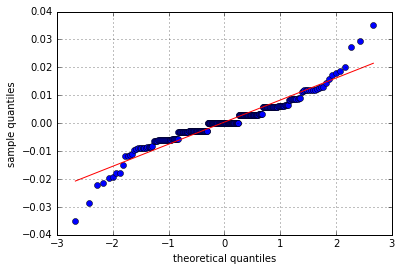


Results for stock 510210


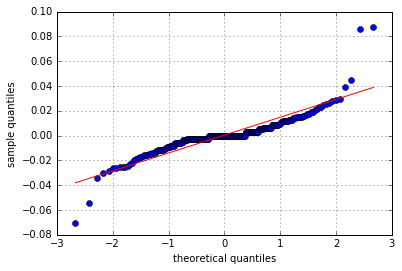


Results for stock 513500


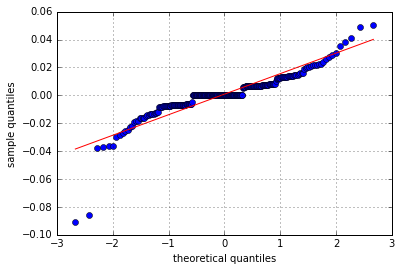

In [8]:
for st in stock:
    print '\nResults for stock %s' %st
    sm.qqplot(retData[st].dropna(),line = 's')
    plt.grid(True)
    plt.xlabel('theoretical quantiles')
    plt.ylabel('sample quantiles')
    plt.show()

很显然，样本的分位数值不在一条直线上，表明“非正态性”。左侧和右侧分别有许多值远低于和远高于直线。这是典型的Fat tails。 Fat tails是频数分布中观察到的两端的异常值。

### **7.进行正态性检验**

In [9]:
def normality_test(array):
    '''
    对给定的数据集进行正态性检验
    组合了3中统计学测试
    偏度测试（Skewtest）——足够接近0
    峰度测试（Kurtosistest)——足够接近0
    正态性测试
    '''
    print 'Skew of data set %15.3f' % scs.skew(array)
    print 'Skew test p-value %14.3f' % scs.skewtest(array)[1]
    print 'Kurt of data set %15.3f' % scs.kurtosis(array)
    print 'Kurt test p-value %14.3f' % scs.kurtosistest(array)[1]
    print 'Norm test p-value %14.3f' % scs.normaltest(array)[1]

for st in stock:
    print '\nResults for st %s' %st
    print 32*'-'
    log_data = np.array(retData[st].dropna())
    normality_test(log_data)


Results for st 510300
--------------------------------
Skew of data set           0.025
Skew test p-value          0.864
Kurt of data set           4.014
Kurt test p-value          0.000
Norm test p-value          0.000

Results for st 510210
--------------------------------
Skew of data set           1.081
Skew test p-value          0.000
Kurt of data set          11.604
Kurt test p-value          0.000
Norm test p-value          0.000

Results for st 513500
--------------------------------
Skew of data set          -1.457
Skew test p-value          0.000
Kurt of data set          10.235
Kurt test p-value          0.000
Norm test p-value          0.000


从上述测试的p值来看，否定了数据集呈正态分布的测试假设。
这说明，**股票市场收益率的正态假设不成立**。

---

## PART TWO：均值-方差投资组合理论

该理论基于用均值和方差来表述组合的优劣的前提。将选取几只股票，用蒙特卡洛模拟初步探究组合的有效前沿。

通过最大Sharpe和最小方差两种优化来找到最优的资产组合配置权重参数。

最后，刻画出可能的分布，两种最优以及组合的有效前沿。

### **1.数据获取**

数据同上



### **2.计算不同证券的均值、协方差**

每年252个交易日，用每日收益得到年化收益。

计算投资资产的协方差是构建资产组合过程的核心部分。运用pandas内置方法生产协方差矩阵。

In [10]:
def get_covmat(retData, tradeDay=252):
    return retData.cov()*tradeDay

In [11]:
cov_mat = get_covmat(retData)
cov_mat.head()

,510300,510210,513500
510300,0.015809,0.007276,0.002535
510210,0.007276,0.052472,0.003319
513500,0.002535,0.003319,0.054773


### **3.给不同资产随机分配初始权重**

由于A股不允许建立空头头寸，所有的权重系数均在0-1之间

In [12]:
# weights standard
weights = np.random.random(cov_mat.shape[0])
weights /= np.sum(weights)
print weights
print np.sum(weights)

[ 0.4233455   0.25075868  0.32589581]
1.0


### **4.计算预期组合年化收益、组合方差和组合标准差**

####  4.1 Portfolio Return
$$ R_p = \Sigma_{i=1}^{N}w_{i}R_{i}$$


In [13]:
# 预期组合年化收益
np.sum(retData.mean()*weights)*252

0.12987710490961965

#### 4.2 Portfolio Risk

$$ \delta (R_w)^2 = w^T \Sigma \delta_{ij}w $$

In [14]:
# measures of riskiness of returns 组合方差
np.dot(np.dot(weights.T, retData.cov()*252),weights)

0.014736792193026954

In [15]:
np.sqrt(np.dot(weights.T, np.dot(retData.cov()* 252,weights)))

0.12139519015606406

### **5.用蒙特卡洛模拟产生大量随机组合**

进行到此，我们最想知道的是给定的一个股票池（证券组合）如何找到风险和收益平衡的位置。

下面通过一次蒙特卡洛模拟，产生大量随机的权重向量，并记录随机组合的预期收益和方差。

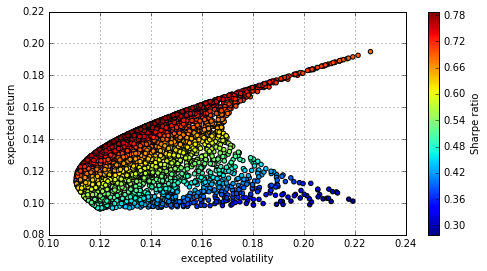

In [16]:
port_returns = []
port_variance = []
for p in range(4000):
    weights = np.random.random(len(stock))
    weights /=np.sum(weights)
    port_returns.append(np.sum(retData.mean()*252*weights))
    port_variance.append(np.sqrt(np.dot(weights.T, np.dot(retData.cov()*252, weights))))

port_returns = np.array(port_returns)
port_variance = np.array(port_variance)

#无风险利率设定为4%
risk_free = 0.04
plt.figure(figsize = (8,4))
plt.scatter(port_variance, port_returns, c=(port_returns-risk_free)/port_variance, marker = 'o')
plt.grid(True)
plt.xlabel('excepted volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')

### **6.投资组合优化1——sharpe最大**

建立statistics函数来记录重要的投资组合统计数据（收益，方差和夏普比）

通过对约束最优问题的求解，得到最优解。其中约束是权重总和为1。

In [17]:
def statistics(weights):
    weights = np.array(weights)
    port_returns = np.sum(retData.mean()*weights)*252
    port_variance = np.sqrt(np.dot(weights.T, np.dot(retData.cov()*252,weights)))
    return np.array([port_returns, port_variance, port_returns/port_variance])

#最优化投资组合的推导是一个约束最优化问题
import scipy.optimize as sco

#最小化夏普指数的负值
def min_sharpe(weights):
    return -statistics(weights)[2]

#约束是所有参数(权重)的总和为1。这可以用minimize函数的约定表达如下
cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})

#我们还将参数值(权重)限制在0和1之间。这些值以多个元组组成的一个元组形式提供给最小化函数
bnds = tuple((0,1) for x in range(noa))

#优化函数调用中忽略的唯一输入是起始参数列表(对权重的初始猜测)。我们简单的使用平均分布。
opts = sco.minimize(min_sharpe, noa*[1./noa,], method = 'SLSQP', bounds = bnds, constraints = cons)
opts

  status: 0
 success: True
    njev: 6
    nfev: 31
     fun: -1.1126163419805777
       x: array([ 0.53841769,  0.10525488,  0.35632743])
 message: 'Optimization terminated successfully.'
     jac: array([ -1.62422657e-06,   4.05609608e-05,  -9.46223736e-06,
         0.00000000e+00])
     nit: 6

得到的最优组合**权重向量**为：

In [18]:
opts['x'].round(3)

array([ 0.538,  0.105,  0.356])

sharpe最大的组合3个**统计数据**分别为：

In [19]:
#预期收益率、预期波动率、最优夏普指数
statistics(opts['x']).round(3)

array([ 0.132,  0.119,  1.113])

### **7.投资组合优化2——方差最小**

接下来，我们通过方差最小来选出最优投资组合。

In [20]:
#但是我们定义一个函数对 方差进行最小化
def min_variance(weights):
    return statistics(weights)[1]

optv = sco.minimize(min_variance, noa*[1./noa,],method = 'SLSQP', bounds = bnds, constraints = cons)
optv

  status: 0
 success: True
    njev: 6
    nfev: 30
     fun: 0.11080019377686823
       x: array([ 0.68846271,  0.1269619 ,  0.18457538])
 message: 'Optimization terminated successfully.'
     jac: array([ 0.11078895,  0.11086498,  0.11079759,  0.        ])
     nit: 6

方差最小的最优组合**权重向量**及**组合的统计数据**分别为：

In [21]:
optv['x'].round(3)

array([ 0.688,  0.127,  0.185])

In [22]:
#得到的预期收益率、波动率和夏普指数
statistics(optv['x']).round(3)

array([ 0.115,  0.111,  1.036])

### **8.组合的有效前沿**

有效前沿有既定的目标收益率下方差最小的投资组合构成。

在最优化时采用两个约束，1.给定目标收益率，2.投资组合权重和为1。

In [23]:
def min_variance(weights):
    return statistics(weights)[1]

#在不同目标收益率水平（target_returns）循环时，最小化的一个约束条件会变化。
target_returns = np.linspace(0.0,0.5,50)
target_variance = []
for tar in target_returns:
    cons = ({'type':'eq','fun':lambda x:statistics(x)[0]-tar},{'type':'eq','fun':lambda x:np.sum(x)-1})
    res = sco.minimize(min_variance, noa*[1./noa,],method = 'SLSQP', bounds = bnds, constraints = cons)
    target_variance.append(res['fun'])

target_variance = np.array(target_variance)

下面是最优化结果的展示。

**叉号**：构成的曲线是有效前沿（目标收益率下最优的投资组合）

**红星**：sharpe最大的投资组合

**黄星**：方差最小的投资组合

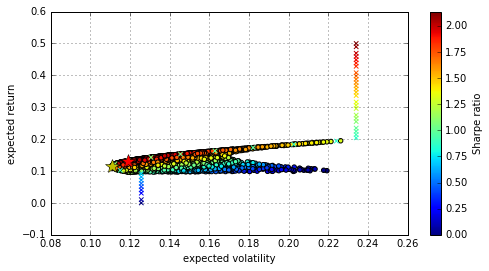

In [24]:
plt.figure(figsize = (8,4))
#圆圈：蒙特卡洛随机产生的组合分布
plt.scatter(port_variance, port_returns, c = port_returns/port_variance,marker = 'o')
#叉号：有效前沿
plt.scatter(target_variance,target_returns, c = target_returns/target_variance, marker = 'x')
#红星：标记最高sharpe组合
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize = 15.0)
#黄星：标记最小方差组合
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize = 15.0)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')

In [25]:
def get_weights(retData):
    
    cov_mat = get_covmat(retData)
    # 根据上面的描述写好对应的P、q、G、h、A、b
    Nums = cov_mat.shape[0]
    P = matrix(cov_mat.values)
    q = matrix(np.zeros(Nums))
    G = matrix(np.diag(-np.ones(Nums)))
    h = matrix(np.zeros(Nums))
    A = matrix(np.ones(Nums)).T
    b = matrix(1.0).T

    # 代入优化方程求解
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    wts = pd.Series(index=cov_mat.index, data=np.array(sol['x']).flatten())
    wts = wts[wts >= 0.0001]  # weights调整，对于权重太小的不予配置
    wts_adjusted = wts / wts.sum() * 1.0
    return wts_adjusted

In [26]:
get_weights(retData)

510300    0.688607
510210    0.126809
513500    0.184583
dtype: float64